# Laboratorio 6

## Wine classification

1. Load the dataset from sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine
wine_dataset = load_wine()
wine_X = wine_dataset["data"]
wine_y = wine_dataset["target"]
wine_feature_names = wine_dataset["feature_names"]

In [3]:
print(wine_X.shape)
print(wine_y.shape)
print(wine_feature_names)

(178, 13)
(178,)
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [4]:
wine_X[np.isnan(wine_X)]

array([], dtype=float64)

In [5]:
from collections import Counter

In [6]:
Counter(wine_y)

Counter({0: 59, 1: 71, 2: 48})

2. Create a DecisionTreeClassifier object with the default configuration

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
clf = DecisionTreeClassifier()

clf = clf.fit(wine_X, wine_y)

3. Now that you have created a tree, you can visualize it

In [9]:
from sklearn.tree import plot_tree

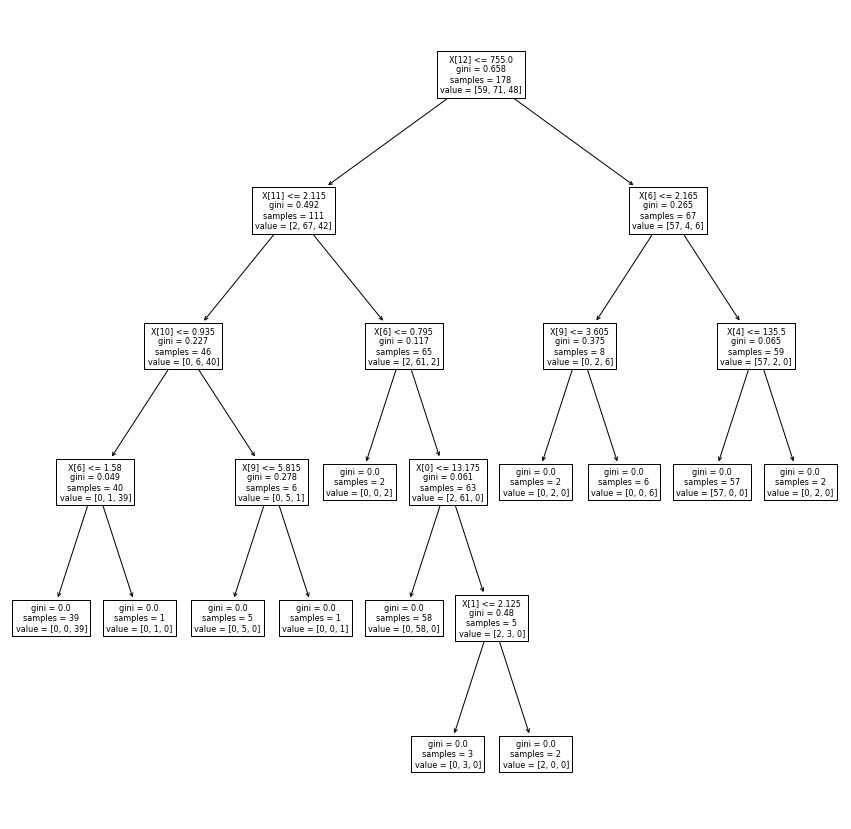

In [12]:
plt.figure(figsize=(15,15))
_ = plot_tree(clf)

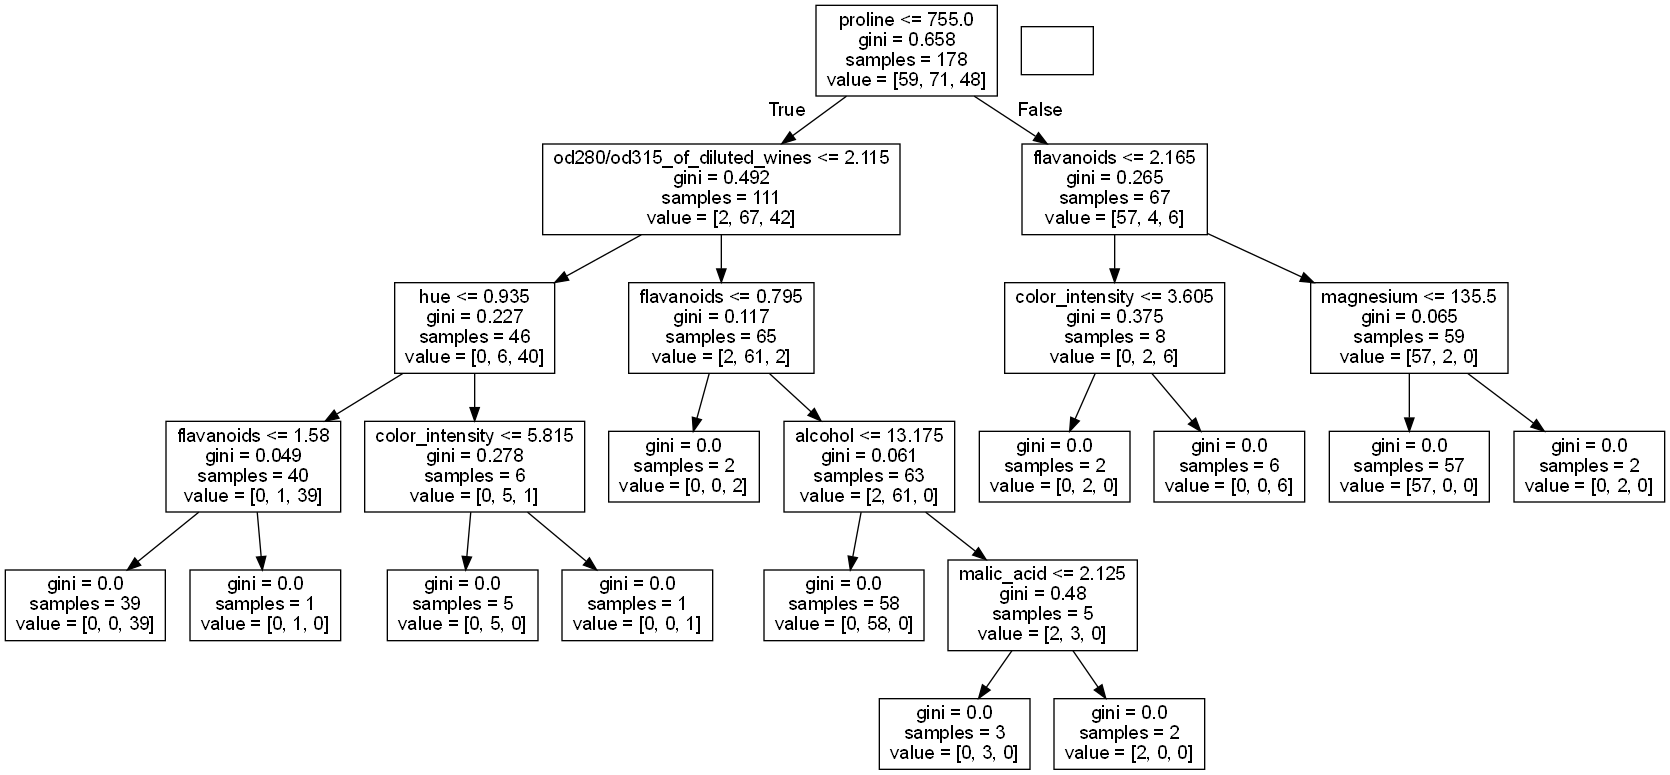

In [11]:
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz
# here, features is a list of names, one for each feature
# this makes the resulting tree visualization more comprehensible
dot_code = export_graphviz(clf, feature_names=wine_feature_names)
graph = pydot.graph_from_dot_data(dot_code)
Image(graph[0].create_png())

In [28]:
from sklearn.metrics import accuracy_score 

accuracy_score(y_true=wine_y, y_pred=clf.predict(wine_X))

1.0

5. Now, we can split our dataset into a training set and a test set

In [46]:
from sklearn.model_selection import train_test_split

wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine_X, wine_y, train_size=.8, stratify = wine_y)

print(wine_X_train.shape) 
print(wine_X_test.shape) 
print(wine_y_train.shape) 
print(wine_y_test.shape) 

(142, 13)
(36, 13)
(142,)
(36,)


In [47]:
clf2 = DecisionTreeClassifier()

clf2.fit(wine_X_train, wine_y_train)

DecisionTreeClassifier()

In [51]:
wine_y_pred = clf2.predict(wine_X_test)

accuracy_score(y_true=wine_y_test, y_pred=clf2.predict(wine_X_test))

0.9722222222222222

In [50]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [52]:
print(confusion_matrix(wine_y_test,wine_y_pred))
print(precision_score(wine_y_test,wine_y_pred,average=None))
print(recall_score(wine_y_test,wine_y_pred,average=None))
print(f1_score(wine_y_test,wine_y_pred,average=None))
print(classification_report(wine_y_test,wine_y_pred))

[[12  0  0]
 [ 1 13  0]
 [ 0  0 10]]
[0.92307692 1.         1.        ]
[1.         0.92857143 1.        ]
[0.96       0.96296296 1.        ]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.93      0.96        14
           2       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

